<a href="https://colab.research.google.com/github/oawonuga92/Music-Recommendation-Using-FP-Growth-algortihm/blob/main/Music_Recommendation_using_Frequent_itemset_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**You will write your code in this worksheet**

**YOUR CODE WILL BE CHECKED FOR PLAGIARISM**

**Initial Setup**

1. First, you will setup your CoLab environment.

2. Then, you will authenticate a Google Drive client to download the file we will be processing in our Spark job.
Make sure to follow the interactive instructions.

3. Then, you will download the dataset `lastfm.csv` and store it in your drive.
Check the panel in your left to note if the dataset has downloaded correctly under the "Files" tab.

** **

### **PROJECT TITLE : Applying Frequent Itemset Pattern Mining Algorithm for Music Recommendation based on user music listening behaviour**

**Dataset: LastFm music listening history data**

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-11-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 35 kB/s 
     |████████████████████████████████| 199 kB 24.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=3050479493911eb6933907a48ea38df22b8411e75a94385fd57523220b9994c2
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark
openjdk-11-jdk-headless is already the newest version (11.0.17+8-1ubuntu2~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
file_list = drive.ListFile({'q': "'1iUsSO-Fo5D5c0YX9_6RgA1cy4IK_Da4-' in parents"}).GetList()
for f in file_list:
  print('title: %s, id: %s' % (f['title'], f['id']))

In [ ]:
id='1q7iH1KpSPEtd35NAOqvA35mikPhracDY'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('lastfm.csv')

***Check whether your dataset was downloaded and stored correctly***

** **

**First, we will import all libraries neccessary to conduct data exploration**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.ml.fpm import FPGrowth

** **

**Next, we create the sparksession. The sparksession is the gateway point to work with pyspark.**

**After creating sparksession, we create an instance of sparksession (sparksession context) to work with dataframe or run SQL queries on dataframe**

In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [ ]:
os.environ["SPARK_HOME"] = "/content/spark-2.4.6-bin-hadoop2.7"

** **

**After creating the instance of sparksession, use the sparkcontext call up the read.csv fucntion to load the dataset into a dataframe**  

In [ ]:
lastfm_df = spark.read.csv('/content/lastfm.csv', header=True, inferSchema=True)

** **

### **RUNNING DATA EXPLORATION QUERIES ON THE DATAFRAME USING PySpark**

**Action 1: PrintSchema of the dataframe to view datatype of each column**

In [ ]:
#Display the lastfm dataframe schema showing column name and data type
lastfm_df.printSchema()

root
 |-- user: integer (nullable = true)
 |-- artist: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- country: string (nullable = true)



In [ ]:
lastfm_df.describe().show()

+-------+------------------+--------------------+------+-----------+
|summary|              user|              artist|   sex|    country|
+-------+------------------+--------------------+------+-----------+
|  count|            289955|              289955|289955|     289955|
|   mean|  9852.46044731079|  178.03614457831324|  null|       null|
| stddev|5692.3550412356335|  133.76780367937877|  null|       null|
|    min|                 1|...and you will k...|     f|Afghanistan|
|    max|             19718|          Édith piaf|     m|   Zimbabwe|
+-------+------------------+--------------------+------+-----------+



** **

**Action 2: Checking Data types**


In [ ]:
lastfm_df.dtypes

[('user', 'int'),
 ('artist', 'string'),
 ('sex', 'string'),
 ('country', 'string')]

** **

**Action 3:   Display the number of rows in the dataframe**

In [ ]:
lastfm_df.count()

289955

** **

**Action 4: Display the number of columns in the dataframe**

In [ ]:
print(lastfm_df.columns) # .columns function will display the name of each column in a list
len(lastfm_df.columns) # len function will display the number of items (columns) in the list above

['user', 'artist', 'sex', 'country']


4

** **

**Action 5:  Display the size(shape) of the dataframe**


In [ ]:
no_of_rows = lastfm_df.count() #store the no. of rows using .count() into the variable no_of_rows
no_of_columns = len(lastfm_df.columns) #store the no. of columns using len function into the variable no_of_columns

print(f'size of the Dataframe is: {(no_of_rows, no_of_columns)}')

size of the Dataframe is: (289955, 4)


** ** **

**Action 6: Display the First 10 rows of the dataframe**

In [ ]:
lastfm_df.show(10)

+----+--------------------+---+-------+
|user|              artist|sex|country|
+----+--------------------+---+-------+
|   1|red hot chili pep...|  f|Germany|
|   1|the black dahlia ...|  f|Germany|
|   1|           goldfrapp|  f|Germany|
|   1|    dropkick murphys|  f|Germany|
|   1|            le tigre|  f|Germany|
|   1|          schandmaul|  f|Germany|
|   1|               edguy|  f|Germany|
|   1|        jack johnson|  f|Germany|
|   1|           eluveitie|  f|Germany|
|   1|         the killers|  f|Germany|
+----+--------------------+---+-------+
only showing top 10 rows



** **

**Action 7: Display the Last 10 rows of the dataframe**

In [ ]:
lastfm_df.tail(10)


[Row(user=19718, artist='david bowie', sex='f', country='Canada'),
 Row(user=19718, artist='mgmt', sex='f', country='Canada'),
 Row(user=19718, artist='cold war kids', sex='f', country='Canada'),
 Row(user=19718, artist='fleetwood mac', sex='f', country='Canada'),
 Row(user=19718, artist='arcade fire', sex='f', country='Canada'),
 Row(user=19718, artist='bob dylan', sex='f', country='Canada'),
 Row(user=19718, artist='pixies', sex='f', country='Canada'),
 Row(user=19718, artist='the clash', sex='f', country='Canada'),
 Row(user=19718, artist='a tribe called quest', sex='f', country='Canada'),
 Row(user=19718, artist='radiohead', sex='f', country='Canada')]

** **

**Action 8: Display each distinct user (listener) and thier respective countries; First 10 rows and Last 5 rows**

In [ ]:
lastfm_df.dropDuplicates(['user']).select("user","country").show(10)
lastfm_df.dropDuplicates(['user']).select("user","country").tail(5)

+----+------------------+
|user|           country|
+----+------------------+
|   1|           Germany|
|   3|     United States|
|   4|    United Kingdom|
|   5|           Finland|
|   6|          Portugal|
|   7|           Finland|
|   9|     United States|
|  12|             Italy|
|  13|           Austria|
|  14|Korea, Republic of|
+----+------------------+
only showing top 10 rows



[Row(user=19713, country='Ukraine'),
 Row(user=19714, country='United Kingdom'),
 Row(user=19715, country='United Kingdom'),
 Row(user=19717, country='Brazil'),
 Row(user=19718, country='Canada')]

** **

**Action 9: Count the number of distinct items in each column of the dataframe [ 'user', 'artist', 'sex', 'country' ]**

In [ ]:
print(lastfm_df.select(max('user'), min('user')).show())
print (" ")

print ("The Number of distinct User is:", lastfm_df.select('user').distinct().count())
print ("The Number of distinct Artist is:", lastfm_df.select('artist',).distinct().count())
print ("The Number of distinct Country is:", lastfm_df.select('country').distinct().count())

+---------+---------+
|max(user)|min(user)|
+---------+---------+
|    19718|        1|
+---------+---------+

None
 
The Number of distinct User is: 15000
The Number of distinct Artist is: 1004
The Number of distinct Country is: 159


** **

### **DATA PRE-PROCESSING TECHNIQUES**

**1. DATA CLEANING**

**Validation to find missing or null values**

In [ ]:
df = ['user','artist','sex','country']
lastfm_df.select([count(col(any_row)).isNull() for any_row in df]).show()

df = ['user','artist','sex','country']
lastfm_df.select([count(col(any_row).isNull()) for any_row in df]).show()

+---------------------+-----------------------+--------------------+------------------------+
|(count(user) IS NULL)|(count(artist) IS NULL)|(count(sex) IS NULL)|(count(country) IS NULL)|
+---------------------+-----------------------+--------------------+------------------------+
|                false|                  false|               false|                   false|
+---------------------+-----------------------+--------------------+------------------------+

+---------------------+-----------------------+--------------------+------------------------+
|count((user IS NULL))|count((artist IS NULL))|count((sex IS NULL))|count((country IS NULL))|
+---------------------+-----------------------+--------------------+------------------------+
|               289955|                 289955|              289955|                  289955|
+---------------------+-----------------------+--------------------+------------------------+



**2. DATA TRANSFORMATION**

**Removing duplicates**

In [ ]:
#IDENTIFYING DUPLICATES - count the number of duplicate entries and display the row records

import pyspark.sql.functions as psf
lastfm_df.groupBy(lastfm_df.columns).count().where(psf.col('count') > 1).select(psf.sum('count')).show()

import pyspark.sql.functions as psf
lastfm_df.groupBy(lastfm_df.columns).count().where(psf.col('count') > 1).show()



+----------+
|sum(count)|
+----------+
|         4|
+----------+

+----+-----------+---+--------------+-----+
|user|     artist|sex|       country|count|
+----+-----------+---+--------------+-----+
|9753|james brown|  m|       Germany|    2|
|6980|     m.i.a.|  f|United Kingdom|    2|
+----+-----------+---+--------------+-----+



In [ ]:
#DROPPING DUPLICATES FROM THE DATASET
lastfm_df1 = lastfm_df.dropDuplicates(['user','artist','sex','country'])

lastfm_df1.count()

289953

** **

### **OTHER DATA EXPLORATION USING GroupBy, Agg, OrderBy and countDistinct FUNCTIONS**


From this point hencefort, the new dataframe to be used for exploration and transformation will be the normalized dataframe in the previous action 9 which is **"lastfm_df1"**

 **Action 10: the artist that recieved the highest number / least number of radio play from listeners**

In [ ]:
artist_radioplays = lastfm_df1.groupBy('artist').agg(count('artist').alias('frequency of radio plays')).orderBy('frequency of radio plays',ascending=False)

print (artist_radioplays.show(5))          #display the frequency of the top 5 artists and thier frequency of radio plays

artist_radioplays.tail(5)                  #display the frequency of the least 5 music artist and frequency of radio plays

+--------------------+------------------------+
|              artist|frequency of radio plays|
+--------------------+------------------------+
|           radiohead|                    2704|
|         the beatles|                    2668|
|            coldplay|                    2378|
|red hot chili pep...|                    1786|
|                muse|                    1711|
+--------------------+------------------------+
only showing top 5 rows

None


[Row(artist='tarja turunen', frequency of radio plays=99),
 Row(artist='schandmaul', frequency of radio plays=98),
 Row(artist='toto', frequency of radio plays=98),
 Row(artist='mary j. blige', frequency of radio plays=96),
 Row(artist='thin lizzy', frequency of radio plays=96)]

** **

**Action 11: Distribution plot of the frequency of radio plays by artist**

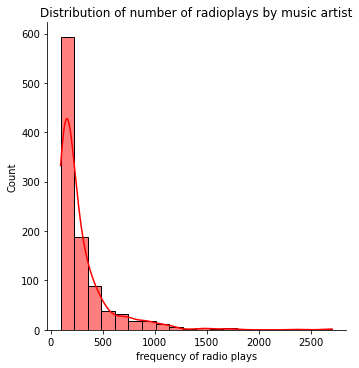

In [ ]:
df_artist_radioplays = artist_radioplays.toPandas()

sb.displot(df_artist_radioplays['frequency of radio plays'], kde=True, bins = 20, color='r')

plt.title("Distribution of number of radioplays by music artist")
plt.savefig('distribution_of_radioplays_by_artist2', bbox_inches = 'tight')

** **

**Action 12: frequency of countries from the entire data observations**

In [ ]:
lastfm_df1.groupBy('country').agg(count('country').alias('frequency_of_country')).orderBy('frequency_of_country',ascending=False).show(10)

+------------------+--------------------+
|           country|frequency_of_country|
+------------------+--------------------+
|     United States|               59558|
|    United Kingdom|               27637|
|           Germany|               24250|
|            Poland|               17111|
|            Sweden|               12379|
|            Brazil|               11922|
|Russian Federation|               11676|
|           Finland|               10157|
|       Netherlands|                9673|
|             Spain|                9322|
+------------------+--------------------+
only showing top 10 rows



** **

**Action 13: Number of users (listeners) that belong to each country**

In [ ]:
unique_country_df = lastfm_df1.groupBy('country').agg(countDistinct('user').alias('no_of_distinct_users (listeners)'))

unique_country_df.orderBy('no_of_distinct_users (listeners)',ascending=False).show(5) #Top 5 countries that had highest number of listeners

unique_country_df.orderBy('no_of_distinct_users (listeners)',ascending=False).tail(5) #Least 5 countries that had least number of listeners

+------------------+--------------------------------+
|           country|no_of_distinct_users (listeners)|
+------------------+--------------------------------+
|     United States|                            2905|
|           Germany|                            1257|
|    United Kingdom|                            1256|
|            Poland|                             983|
|Russian Federation|                             785|
+------------------+--------------------------------+
only showing top 5 rows



[Row(country='Antigua and Barbuda', no_of_distinct_users (listeners)=1),
 Row(country='Luxembourg', no_of_distinct_users (listeners)=1),
 Row(country='Niue', no_of_distinct_users (listeners)=1),
 Row(country='Mauritius', no_of_distinct_users (listeners)=1),
 Row(country='Syrian Arab Republic', no_of_distinct_users (listeners)=1)]

** **

**Action 14: Display the users that listen to the most number / Least number of artists, grouped by the user's country**

In [ ]:
lastfm_df1.groupBy('user','country').agg(count('artist')).orderBy('count(artist)',ascending=False).show(5)  #User that listens to most number of artists

lastfm_df1.groupBy('user','country').agg(count('artist')).orderBy('count(artist)',ascending=False).tail(5)  #User that listens to least number of artists

+-----+-------------+-------------+
| user|      country|count(artist)|
+-----+-------------+-------------+
|17681|  New Zealand|           76|
|15057|United States|           63|
|19558|        Spain|           55|
| 1208|       Mexico|           55|
|13424|      Germany|           54|
+-----+-------------+-------------+
only showing top 5 rows



[Row(user=15569, country='Bosnia and Herzegovina', count(artist)=1),
 Row(user=19065, country='France', count(artist)=1),
 Row(user=1915, country='United States', count(artist)=1),
 Row(user=6068, country='Sweden', count(artist)=1),
 Row(user=9075, country='United Kingdom', count(artist)=1)]

** **

**Action 15 : To find the average number of music artists listened by the male population in each country**

In [ ]:
#Group the dataframe by columns [user, sex, country] and aggregate by the number of artist with a new alias called 'no_of_artist_in_music_playlist'.
#Order the dataframe by the new alias from a descending order
#save the dataframe into a new variable called "lastfm_for_average"
lastfm_for_avg = lastfm_df1.groupBy('user','sex','country').agg(count('artist').alias('no_of_artist_in_music_playlist')).orderBy('no_of_artist_in_music_playlist',ascending=False)

lastfm_avg_male = lastfm_for_avg.filter(lastfm_for_avg.sex == 'm').groupBy('country','sex').agg(avg('no_of_artist_in_music_playlist')).orderBy(avg('no_of_artist_in_music_playlist'), ascending=False)

**

**Bar chart showing the average number of music artists listened by the male population in each country**

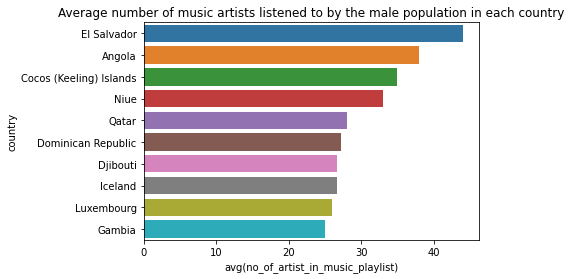

In [ ]:
df_lastfm_avg_male = lastfm_avg_male.toPandas()
sb.barplot(x='avg(no_of_artist_in_music_playlist)', y='country', data=df_lastfm_avg_male.head(10))
plt.title('Average number of music artists listened to by the male population in each country')
plt.savefig('Average number of music artists listened to by the male population.png', bbox_inches = 'tight')

** **

**Action 16 : To find the average number of music artists listened by both male and female population in each country**

In [ ]:
lastfm_for_avg = lastfm_df1.groupBy('user','country').agg(count('artist').alias('no_of_artist_in_music_playlist')).orderBy('no_of_artist_in_music_playlist',ascending=False)

lastfm_avg_per_country = lastfm_for_avg.groupBy('country','user').agg(avg('no_of_artist_in_music_playlist')).orderBy(avg('no_of_artist_in_music_playlist'), ascending=False)

** **

**Action 17: Bar chart showing average number of artists listened by both male and female population in each country**

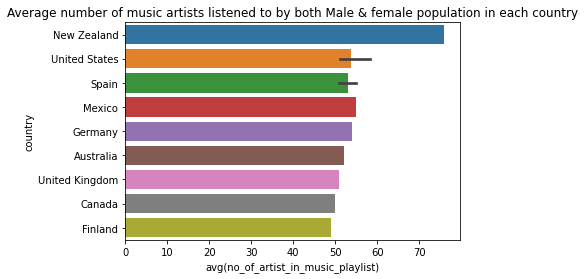

In [ ]:
df_lastfm_avg_per_country = lastfm_avg_per_country.toPandas()

#Plotting the barchart using seaborn
sb.barplot(x='avg(no_of_artist_in_music_playlist)', y='country', data=df_lastfm_avg_per_country.head(15))
plt.title('Average number of music artists listened to by both Male & female population in each country')

#saving the chart
plt.savefig('Average number of music artists listened to by both Male & female population in each country.png', bbox_inches = 'tight')

** **

**Action 18: Count the number of users that are either male or female in every row observation**

In [ ]:
lastfm_df1.groupBy('sex').agg(count('user')).show()

+---+-----------+
|sex|count(user)|
+---+-----------+
|  m|     211822|
|  f|      78131|
+---+-----------+



In [ ]:
#Count the number of distinct users in entire that are Male and Female

lastfm_df1.groupBy('sex').agg(countDistinct('user')).show()

+---+-----------+
|sex|count(user)|
+---+-----------+
|  m|      11149|
|  f|       3851|
+---+-----------+



** **

## **FREQUENT ITEMSET PATTERN MINING**

**TASK 1:** **We first group the *lastfm_df1* dataframe by column [ 'user' ] and collect a user's listening history to obtain a single row per user that captures the list of user music_playlist_history**

In [ ]:
#save the grouped dataframe into a new variable called 'lastfm_df_grouped'

lastfm_df_grouped = lastfm_df1.groupBy('user','sex','country').agg({'artist': 'collect_list'}).toDF('user', 'sex','country','music_artist_playlist')
lastfm_df_grouped.show(5)

+----+---+--------------+---------------------+
|user|sex|       country|music_artist_playlist|
+----+---+--------------+---------------------+
|   3|  m| United States| [pavement, mf doo...|
|   4|  m|United Kingdom| [the flaming lips...|
|   6|  m|      Portugal| [muse, dream thea...|
|   7|  m|       Finland| [alice in chains,...|
|   9|  m| United States| [children of bodo...|
+----+---+--------------+---------------------+
only showing top 5 rows



** **

**TASK 2:**    **The variable created in task1 which contains user's music listening history is Split into 80% test_data and 20% train_data**

In [ ]:
lastfm_df_train_data, lastfm_df_test_data = lastfm_df_grouped.randomSplit (weights = [0.8,0.2], seed = 200)

In [ ]:
print(lastfm_df_train_data.count())
print(lastfm_df_test_data.count())

11954
3046


** ** 

**TASK 3: We use MLlib, Apache Spark's scalable machine learning library 
to implement FP-Growth algorithm using four different set parameters of support (S) and confidence (C)**

In [ ]:
#Four tests are perfrormed using minimum support and confidence values. Each of the four FP-growth algorithms is stored in a variable
fp_growth_1 = FPGrowth(itemsCol = "music_artist_playlist", minSupport = 0.02, minConfidence = 0.3)
fp_growth_2 = FPGrowth(itemsCol = "music_artist_playlist", minSupport = 0.01, minConfidence = 0.3)
fp_growth_3 = FPGrowth(itemsCol = "music_artist_playlist", minSupport = 0.001, minConfidence = 0.5)
fp_growth_4 = FPGrowth(itemsCol = "music_artist_playlist", minSupport = 0.006, minConfidence = 0.3)

#Each of the 4 FP-growth test algorithms is fit with 80% train data
lastfm_model_test1 = fp_growth_1.fit(lastfm_df_train_data)
lastfm_model_test2 = fp_growth_2.fit(lastfm_df_train_data)
lastfm_model_test3 = fp_growth_3.fit(lastfm_df_train_data)
lastfm_model_test4 = fp_growth_4.fit(lastfm_df_train_data)

** **

**TASK 4: We compute the Frequent itemset count and Association Rules count for each of the 4 FP-growth test algorithm**

In [ ]:
print(lastfm_model_test1.freqItemsets.count(), 'Frequent itemsets for model 1')
print(lastfm_model_test1.associationRules.count(), 'Association rules for model 1')
print("")
print(lastfm_model_test2.freqItemsets.count(), 'Frequent itemsets for model 2')
print(lastfm_model_test2.associationRules.count(),'Association rules for model 2')
print("")
print(lastfm_model_test3.freqItemsets.count(), 'Frequent itemsets for model 3')
print(lastfm_model_test3.associationRules.count(), 'Association rules for model 3')
print("")
print(lastfm_model_test4.freqItemsets.count(), 'Frequent itemsets for model 4')
print(lastfm_model_test4.associationRules.count(), 'Association rules for model 4')

396 Frequent itemsets for model 1
86 Association rules for model 1

1662 Frequent itemsets for model 2
477 Association rules for model 2

281045 Frequent itemsets for model 3
194322 Association rules for model 3

4936 Frequent itemsets for model 4
2197 Association rules for model 4


** **

**TASK 5: We show a compute the first 3 names and last 3 names of the frequent music artists**

In [ ]:
#Each of the 4 test FP growth model will show their top 3 frequent music artist
lastfm_model_test1.freqItemsets.sort(desc('freq')).show(3)
lastfm_model_test2.freqItemsets.sort(desc('freq')).show(3)
lastfm_model_test3.freqItemsets.sort(desc('freq')).show(3)
lastfm_model_test4.freqItemsets.sort(desc('freq')).show(3)

#Each of the 4 test FP growth model will show their least 3 frequent music artist
least_freq1 = lastfm_model_test1.freqItemsets.sort(desc('freq')).tail(3);   print(least_freq1)
least_freq2 = lastfm_model_test2.freqItemsets.sort(desc('freq')).tail(3);   print(least_freq2)
least_freq3 = lastfm_model_test3.freqItemsets.sort(desc('freq')).tail(3);   print(least_freq3)
least_freq4 = lastfm_model_test4.freqItemsets.sort(desc('freq')).tail(3);   print(least_freq4)

+-------------+----+
|        items|freq|
+-------------+----+
|  [radiohead]|2117|
|[the beatles]|2108|
|   [coldplay]|1884|
+-------------+----+
only showing top 3 rows

+-------------+----+
|        items|freq|
+-------------+----+
|  [radiohead]|2117|
|[the beatles]|2108|
|   [coldplay]|1884|
+-------------+----+
only showing top 3 rows

+-------------+----+
|        items|freq|
+-------------+----+
|  [radiohead]|2117|
|[the beatles]|2108|
|   [coldplay]|1884|
+-------------+----+
only showing top 3 rows

+-------------+----+
|        items|freq|
+-------------+----+
|  [radiohead]|2117|
|[the beatles]|2108|
|   [coldplay]|1884|
+-------------+----+
only showing top 3 rows

[Row(items=['snoop dogg'], freq=241), Row(items=['modest mouse', 'radiohead'], freq=240), Row(items=['cansei de ser sexy'], freq=240)]
[Row(items=['mgmt', 'arctic monkeys'], freq=120), Row(items=['r.e.m.', 'david bowie'], freq=120), Row(items=['nickelback', 'red hot chili peppers'], freq=120)]
[Row(items=['joss

** **

**TASK 6: We want to view the highest lift value for each antecedent and consequent in each of the 4 FP-Growth test models**

In [ ]:
lastfm_model_test1.associationRules.sort(desc('lift')).show(1)
lastfm_model_test2.associationRules.sort(desc('lift')).show(1)
lastfm_model_test3.associationRules.sort(desc('lift')).show(1)
lastfm_model_test4.associationRules.sort(desc('lift')).show(1)

+----------------+------------+-------------------+-----------------+--------------------+
|      antecedent|  consequent|         confidence|             lift|             support|
+----------------+------------+-------------------+-----------------+--------------------+
|[massive attack]|[portishead]|0.33676092544987146|5.076469234335137|0.021917349841057386|
+----------------+------------+-------------------+-----------------+--------------------+
only showing top 1 row

+----------+----------+------------------+------------------+--------------------+
|antecedent|consequent|        confidence|              lift|             support|
+----------+----------+------------------+------------------+--------------------+
|   [jay-z]|     [nas]|0.3548387096774194|14.626696329254727|0.010122134850259328|
+----------+----------+------------------+------------------+--------------------+
only showing top 1 row

+--------------------+---------------+------------------+------------------+------

** **

**TASK 7: We gauge the performance of each of the 4 FP-Growth testmodels by running the training data on each model**

In [ ]:
music_prediction_output_1 = lastfm_model_test1.transform(lastfm_df_train_data)
music_prediction_output_2 = lastfm_model_test2.transform(lastfm_df_train_data)
music_prediction_output_3 = lastfm_model_test3.transform(lastfm_df_train_data)
music_prediction_output_4 = lastfm_model_test4.transform(lastfm_df_train_data)


** **

**Each of the 4 Music prediction model was tested using user id = 154 to find out the music recommendation accuracy and performance**

In [ ]:
music_prediction_output_1.filter(music_prediction_output_1.user == 154).show(50,False)
music_prediction_output_2.filter(music_prediction_output_2.user == 154).show(50,False)
music_prediction_output_3.filter(music_prediction_output_3.user == 154).show(50,False)
music_prediction_output_4.filter(music_prediction_output_4.user == 154).show(50,False)

+----+---+-------+-------------------------------------------------------------------------------------------+----------+
|user|sex|country|music_artist_playlist                                                                      |prediction|
+----+---+-------+-------------------------------------------------------------------------------------------+----------+
|154 |m  |Poland |[mgmt, damian marley, erykah badu, matisyahu, snoop dogg, the prodigy, 50 cent, bob marley]|[]        |
+----+---+-------+-------------------------------------------------------------------------------------------+----------+

+----+---+-------+-------------------------------------------------------------------------------------------+----------------------------------+
|user|sex|country|music_artist_playlist                                                                      |prediction                        |
+----+---+-------+-------------------------------------------------------------------------------